(1000, 52) (1000, 52) (1000,) (1000,)


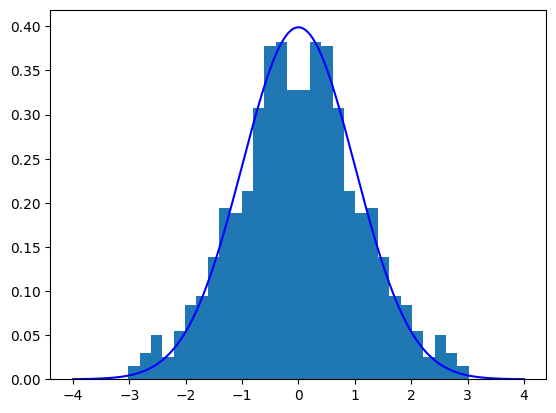

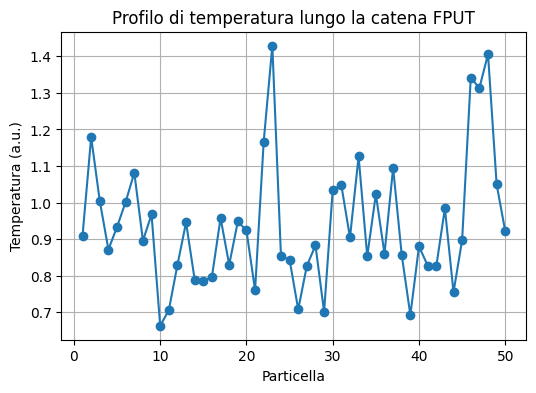

In [58]:
import jax.numpy as jnp
import numpy as np
import os
import matplotlib.pyplot as plt
from jax import config
config.update("jax_enable_x64", True)
def read_conditions_fput_parallel(filename, num_condizioni, N):
    """
    Legge num_condizioni random dal file binario simultaneamente usando memmap.

    Args:
        filename: str, path al file binario
        num_condizioni: int, numero di condizioni da leggere
        N: int, numero di masse mobili

    Returns:
        x: jnp.array, shape (num_condizioni, N+2)
        p: jnp.array, shape (num_condizioni, N+2)
        xiL: jnp.array, shape (num_condizioni,)
        xiR: jnp.array, shape (num_condizioni,)
    """
    neq = 2*(N+2)+2
    cond_size_bytes = neq * 8  # double = 8 byte

    # dimensione totale file
    total_size = os.path.getsize(filename)
    total_cond = total_size // cond_size_bytes

    if num_condizioni > total_cond:
        raise ValueError(f"Requested {num_condizioni} conditions, but file has only {total_cond}")

    # seleziona indici casuali
    indices = np.arange(total_cond)
    #np.random.shuffle(indices)
    selected_indices = indices[:num_condizioni//2]

    # crea memmap (file letto solo quando necessario)
    mm = np.memmap(filename, dtype=np.float64, mode='r', shape=(total_cond, neq))

    # leggi le condizioni richieste in batch
    data = mm[selected_indices]

    # separa x, p, xiL, xiR
    x = jnp.array(data[:, 0:-2:2])
    p = jnp.array(data[:, 1:-2:2])
    xiL = jnp.array(data[:, -2])
    xiR = jnp.array(data[:, -1])

    x=jnp.concatenate([x,x],axis=0)
    p=jnp.concatenate([p,-p],axis=0)
    xiL=jnp.concatenate([xiL,-xiL],axis=0)
    xiR=jnp.concatenate([xiR,-xiR],axis=0)
    return x, p, xiL, xiR
N=50

n_chains=1000
# esempio
filename = f"../condizioni_{N}.bin"
x0, p0, xiL0, xiR0 = read_conditions_fput_parallel(filename, n_chains, N)
print(x0.shape, p0.shape, xiL0.shape, xiR0.shape)
plt.hist(xiL0,bins=30,density=True)

# Generate points for x-axis
x = np.linspace(-4, 4, 1000)

# Calculate Gaussian/Normal distribution (μ=0, σ=1)
y = 1/(np.sqrt(2*np.pi)) * np.exp(-x**2/2)

plt.plot(x, y, 'b-', label='Gaussian Distribution')

T_profile = jnp.mean(p0[:, 1:-1]**2, axis=0)



plt.figure(figsize=(6,4))
plt.plot(jnp.arange(1, 50+1), T_profile, marker='o')
plt.xlabel("Particella")
plt.ylabel("Temperatura (a.u.)")
plt.title("Profilo di temperatura lungo la catena FPUT")
plt.grid(True)
plt.show()


Simulazione completata in 3.31s
(10000, 1000)


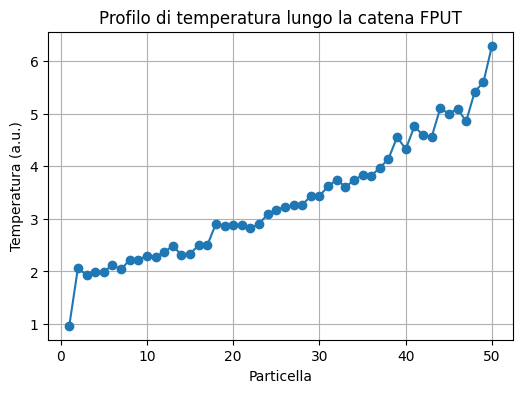

[ 0.          1.72592262  2.4011738   3.90853454  3.55529973  3.79305208
  7.03339842  8.328423    8.0135404   8.00973387 10.69173612 10.86637036
 12.51055449 12.66964076 13.72989292 13.83215405 14.71465633 15.00893969
 15.39348954 15.65852568 15.47774736 17.77254703 19.18947144 21.62425264
 23.57252205 25.45745941 27.31561939 28.95647639 31.05596155 32.84758188
 31.97766695 32.03894891 32.78890278 33.1375486  34.03153052 34.64455583
 34.55931594 35.85745052 38.9127837  40.44042439 42.35326253 42.86458692
 42.98624566 44.38331553 43.67471291 46.07219131 46.97587295 47.66808311
 47.66592081 49.74273197 52.06456801 51.        ]


In [ ]:
import jax
import jax.numpy as jnp
from jax import lax
import matplotlib.pyplot as plt
import time
from diffrax import Dopri5
import jax.numpy as jnp
import numpy as np
import os
import matplotlib.pyplot as plt




# ------------------------------------------------------
# PARAMETRI DEL SISTEMA FPUT CON TERMOSTATI
# ------------------------------------------------------
N = 50               # numero di masse mobili
m = 1.0
a = 1.0               # distanza di equilibrio
chi = 1.0
alpha = 1.0
beta = 1.0
grad_T=0.1

Tl = 1.0    # temperature dei termostati sinistro e destro
Tr=Tl+N*grad_T

thetaL, thetaR = 1.0, 1.0

dt = 0.01
t_steps = 10000
save_every = 1

n_chains = 1000      # simulazioni parallele

# esempio
filename = f"../condizioni_{N}.bin"
x0, p0, xiL0, xiR0 = read_conditions_fput_parallel(filename, n_chains, N)

# ------------------------------------------------------
# RHS DEL SISTEMA (FPUT + TERMOSTATI)
# ------------------------------------------------------
def rhs_fput(x, p, xi_L, xi_R):
    """Equazioni del moto per tutte le catene."""
    # Derivate
    dxdt = p / m
    dpdt = jnp.zeros_like(p)

    # differenze tra posizioni adiacenti
    r_right = x[:, 2:] - x[:, 1:-1] - a
    r_left  = x[:, 1:-1] - x[:, :-2] - a

    # forza FPUT interna
    F_int = chi * (x[:, 2:] + x[:, :-2] - 2*x[:, 1:-1]) \
            + alpha * (r_right**2 - r_left**2) \
            + beta * (r_right**3 - r_left**3)

    # assegna alle particelle interne
    dpdt = dpdt.at[:, 1:-1].set(F_int)

    # accoppiamento con termostati (Nosé–Hoover)
    dpdt = dpdt.at[:, 1].add(-xi_L * p[:, 1])
    dpdt = dpdt.at[:, -2].add(-xi_R * p[:, -2])

    # derivate dei termostati
    kin_L = (p[:, 1]**2) / m
    kin_R = (p[:, -2]**2) / m

    dxi_L = (kin_L / Tl - 1.0) / thetaL**2
    dxi_R = (kin_R / Tr - 1.0) / thetaR**2

    # estremi fissi
    dxdt = dxdt.at[:, 0].set(0.0)
    dxdt = dxdt.at[:, -1].set(0.0)
    dpdt = dpdt.at[:, 0].set(0.0)
    dpdt = dpdt.at[:, -1].set(0.0)

    return dxdt, dpdt, dxi_L, dxi_R


# ------------------------------------------------------
# PASSO RK4
# ------------------------------------------------------
def rk4_step(x, p, xi_L, xi_R, dt):
    def f(x, p, xi_L, xi_R):
        return rhs_fput(x, p, xi_L, xi_R)

    k1x, k1p, k1xiL, k1xiR = f(x, p, xi_L, xi_R)
    k2x, k2p, k2xiL, k2xiR = f(x + 0.5*dt*k1x,
                               p + 0.5*dt*k1p,
                               xi_L + 0.5*dt*k1xiL,
                               xi_R + 0.5*dt*k1xiR)
    k3x, k3p, k3xiL, k3xiR = f(x + 0.5*dt*k2x,
                               p + 0.5*dt*k2p,
                               xi_L + 0.5*dt*k2xiL,
                               xi_R + 0.5*dt*k2xiR)
    k4x, k4p, k4xiL, k4xiR = f(x + dt*k3x,
                               p + dt*k3p,
                               xi_L + dt*k3xiL,
                               xi_R + dt*k3xiR)
    x_new = x + dt*(k1x + 2*k2x + 2*k3x + k4x)/6.0
    p_new = p + dt*(k1p + 2*k2p + 2*k3p + k4p)/6.0
    xi_L_new = xi_L + dt*(k1xiL + 2*k2xiL + 2*k3xiL + k4xiL)/6.0
    xi_R_new = xi_R + dt*(k1xiR + 2*k2xiR + 2*k3xiR + k4xiR)/6.0
    return x_new, p_new, xi_L_new, xi_R_new

def omega0_fn(T):
    return xiR0*p0[:,-2]**2*(1/Tr-1/T)+xiL0*p0[:,1]**2*(1/Tl-1/T)

omega0=omega0_fn(1.)

def observable_bulk(x,p):    
    bd_paticle = int(N*0.15)
    segment = x[:,bd_paticle:N-bd_paticle]
    r = jnp.diff(segment,axis=1)-a
    return ((chi*r+alpha*r**2+beta*r**3)*p[:,bd_paticle:N-bd_paticle]/m).mean(axis=1)


# ------------------------------------------------------
# SIMULAZIONE MULTI-CATENA
# ------------------------------------------------------
def simulate_multi(x0, p0, xiL0, xiR0, dt, t_steps, save_every):
    def body(carry, step):
        x, p, xiL, xiR= carry
        x, p, xiL, xiR = rk4_step(x, p, xiL, xiR, dt)
        #scrivi per salvare
        return (x, p, xiL, xiR), omega0*observable_bulk(x,p)

    init = (x0, p0, xiL0, xiR0)
    (x_final, p_final, xiL_final, xiR_final), store = lax.scan(body, init, jnp.arange(t_steps))
    return x_final, p_final, xiL_final, xiR_final,store



# ------------------------------------------------------
# ESECUZIONE
# ------------------------------------------------------
simulate_multi_jit = jax.jit(simulate_multi, static_argnames=("t_steps", "save_every"))
start = time.time()
x_final, p_final, xiL_final, xiR_final,store = simulate_multi_jit(x0, p0, xiL0, xiR0, dt, t_steps, save_every)
end = time.time()
print(f"Simulazione completata in {end - start:.2f}s")
print(store.shape)
# ------------------------------------------------------
# PROFILO DI TEMPERATURA
# ------------------------------------------------------
T_profile = jnp.mean(p_final[:, 1:-1]**2 / m, axis=0)



plt.figure(figsize=(6,4))
plt.plot(jnp.arange(1, N+1), T_profile, marker='o')
plt.xlabel("Particella")
plt.ylabel("Temperatura (a.u.)")
plt.title("Profilo di temperatura lungo la catena FPUT")
plt.grid(True)
plt.show()

print(x_final[0])

6.0


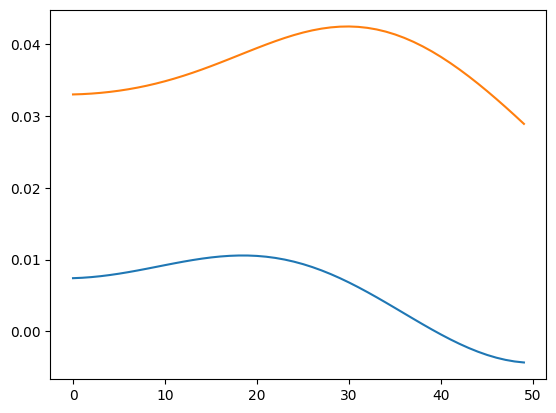

In [76]:
print(Tr)
plt.plot(store.mean(axis=1)[:50])

import numpy as np

# Legge un valore per riga
data = np.loadtxt("/home/dcarbone/catene/test_generation_smalldt_disjoint/ttcf_mil_N_50_Tr_6_39823c.dat", dtype=float)



plt.plot(data[:50])


In [70]:
print((observable_bulk(x0,p0)*omega0).mean())

0.009415152318839996
